# Parametric simulation using accim custom models

In [1]:
#todo import qgrid to manually change output dfs

In [1]:
import accim
from accim.parametric_and_optimisation.objectives import return_time_series
from besos import eppy_funcs as ef
from matplotlib import pyplot as plt
import seaborn as sns
from accim.utils import print_available_outputs_mod
from accim.parametric_and_optimisation.main import OptimParamSimulation, get_rdd_file_as_df, get_mdd_file_as_df, parse_mtd_file
from os import listdir


C:\Users\usuario\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Let's have a look at the files we currently have in the path:

In [2]:
original_files = [i for i in listdir()]
original_files

['.ipynb_checkpoints',
 'param_sim_accim_custom_model.ipynb',
 'param_sim_accim_predefined_model.ipynb',
 'Seville.epw',
 'Sydney.epw',
 'TestModel.idf',
 '__init__.py']

Firstly, the IDF must be read using besos's `get_building` function.

In [3]:
building = ef.get_building('TestModel.idf')

For this analysis, we want to use the HVAC system in all hours of the year, so that temperature is always comfortable. Therefore, we are going to set the occupancy to always on by means of the function `accim.utils.set_occupancy_to_always`, in which we input the IDF class instance we read in the previous cell.

In [4]:
accim.utils.set_occupancy_to_always(idf_object=building)

On 24/7 Schedule:Compact object was already in the model.
People Block1:Zone2 Number of People Schedule Name has been set to always occupied.
People Block1:Zone1 Number of People Schedule Name has been set to always occupied.


Now, let's start with the settings for the parametric analysis. First, let's instantiate the class `OptimParamSimulation`, and let's pass the IDF instance in the argument `building`. Argument `parameters_type` can take 3 different strings:
- "accim predefined model", in which models are those previously defined in accim (ComfStand=0 to ComfStand=22);
- "accim custom model", in which key parameters of the adaptive comfort model are defined in the relevant arguments;
- "apmv setpoints", in which setpoints are based on the aPMV (Adaptive Predicted Mean Vote) instead of the PMV index;

In this case, we're going to use the 'accim custom model' type, in which we can define the adaptive comfort model.

In [5]:
parametric = OptimParamSimulation(
    building=building,
    parameters_type='accim custom model',
    #output_type='standard', #
    #output_keep_existing=False, #
    #output_freqs=['hourly'], #
    #ScriptType='vrf_mm', #
    #SupplyAirTempInputMethod='temperature difference', #
    #debugging=True, #
    #verbosemode=False #
)


--------------------------------------------------------
Adaptive-Comfort-Control-Implemented Model (ACCIM) v0.7.5
--------------------------------------------------------

This tool allows to apply adaptive setpoint temperatures. 
For further information, please read the documentation: 
https://accim.readthedocs.io/en/master/
For a visual understanding of the tool, please visit the following jupyter notebooks:
-    Using addAccis() to apply adaptive setpoint temperatures
https://accim.readthedocs.io/en/master/jupyter_notebooks/addAccis/using_addAccis.html
-    Using rename_epw_files() to rename the EPWs for proper data analysis after simulation
https://accim.readthedocs.io/en/master/jupyter_notebooks/rename_epw_files/using_rename_epw_files.html
-    Using runEp() to directly run simulations with EnergyPlus
https://accim.readthedocs.io/en/master/jupyter_notebooks/runEp/using_runEp.html
-    Using the class Table() for data analysis
https://accim.readthedocs.io/en/master/jupyter_notebo

An initial and generic version of the Adaptive-Comfort-Control-Implementation Script (ACCIS) has been added to the idf instance `building`. For instance, you can take a look at the parameter values accis currently has:

In [6]:
[i for i in building.idfobjects['energymanagementsystem:program'] if i.Name.lower() == 'setinputdata']

[
 ENERGYMANAGEMENTSYSTEM:PROGRAM,
     SetInputData,             !- Name
     set ComfStand = 1,        !- Program Line 1
     set CAT = 1,              !- Program Line 2
     set ComfMod = 2,          !- Program Line 3
     set HVACmode = 2,         !- Program Line 4
     set VentCtrl = 0,         !- Program Line 5
     set VSToffset = 0,        !- Program Line 6
     set MinOToffset = 7,      !- Program Line 7
     set MaxWindSpeed = 6,     !- Program Line 8
     set ACSTtol = -0.25,      !- Program Line 9
     set AHSTtol = 0.25,       !- Program Line 10
     set CoolSeasonStart = 121,    !- Program Line 11
     set CoolSeasonEnd = 274;    !- Program Line 12]

## Setting the outputs

**If you have already read any of the other parametric simulation examples, you can skip this entire outputs section, since it is exactly the same.**

### Outputs for the idf (i.e. the outputs for each simulation run)

First of all, we are going to set the outputs of the simulations that are going to be performed. This is an important step, especially if you are going to run hundreds or thousands of simulations.

Let's take a look at the Output:Variable objects we currently have in the idf. The method `get_output_var_df_from_idf()` returns a pandas DataFrame which contains the information of the existing Output:Variable objects in the idf:

In [7]:
df_output_variables_idf = parametric.get_output_var_df_from_idf()
df_output_variables_idf

key_value  \
0                                              *   
1                                              *   
2                                              *   
3                                              *   
4                                              *   
..                                           ...   
72                                             *   
73  BLOCK1_ZONE2 VRF Indoor Unit DX Cooling Coil   
74  BLOCK1_ZONE2 VRF Indoor Unit DX Heating Coil   
75  BLOCK1_ZONE1 VRF Indoor Unit DX Cooling Coil   
76  BLOCK1_ZONE1 VRF Indoor Unit DX Heating Coil   

                                        variable_name reporting_frequency  \
0                                 Comfort Temperature              Hourly   
1               Adaptive Cooling Setpoint Temperature              Hourly   
2               Adaptive Heating Setpoint Temperature              Hourly   
3   Adaptive Cooling Setpoint Temperature_No Toler...              Hourly   
4   Adaptive Heating Setpoint Temperature_No Toler...              Hourly   
..                                                ...                 ...   
72           VRF Heat Pump Heating Electricity Energy              Hourly   
73                    Cooling Coil Total Cooling Rate              Hourly   
74                          Heating Coil Heating Rate              Hourly   
75                    Cooling Coil Total Cooling Rate              Hourly   
76                          Heating Coil Heating Rate              Hourly   

   schedule_name  
0                 
1                 
2                 
3                 
4                 
..           ...  
72                
73                
74                
75                
76                

[77 rows x 4 columns]

now, let's see the Output:Meter objects:

In [8]:
df_output_meters_idf = parametric.get_output_meter_df_from_idf()
df_output_meters_idf.head()

Empty DataFrame
Columns: [key_name, frequency]
Index: []

In this case, we can see there is no Output:Meter. However, there is a large number of Output:Variable objects which might result in heavy simulation outputs. So, let's get rid of some of them. We can drop the rows we want, and then input the modified DataFrame in the method `set_output_var_df_to_idf(outputs_df)`.

In [9]:
df_output_variables_idf = df_output_variables_idf[
    (
        df_output_variables_idf['variable_name'].str.contains('Setpoint Temperature_No Tolerance')
        |
        df_output_variables_idf['variable_name'].str.contains('Zone Operative Temperature')
        |
        df_output_variables_idf['variable_name'].str.contains('Zone Thermal Comfort ASHRAE 55 Adaptive Model Running Average Outdoor Air Temperature')
    )
]
df_output_variables_idf

key_value                                      variable_name  \
3          *  Adaptive Cooling Setpoint Temperature_No Toler...   
4          *  Adaptive Heating Setpoint Temperature_No Toler...   
52         *                         Zone Operative Temperature   
54         *  Zone Thermal Comfort ASHRAE 55 Adaptive Model ...   

   reporting_frequency schedule_name  
3               Hourly                
4               Hourly                
52              Hourly                
54              Hourly

Let's keep only the Output:Variable objects we have filtered using the `set_output_var_df_to_idf(outputs_df)`:

In [10]:
parametric.set_output_var_df_to_idf(outputs_df=df_output_variables_idf)

We have removed all rows except the adaptive heating and cooling setpoints, the operative temperature and the running mean outdoor temperature. Next optional step is adding Output:Meter objects. We can do that using the method `set_output_met_objects_to_idf(output_meters)`, where `output_meters` is a list of Output:Meter key names.

In [11]:
output_meters = [
    'Heating:Electricity',
    'Cooling:Electricity',
    'Electricity:HVAC',
]
parametric.set_output_met_objects_to_idf(output_meters=output_meters)

Let's see Output:Meter objects we currently have after adding these:

In [12]:
df_output_meters_idf = parametric.get_output_meter_df_from_idf()
df_output_meters_idf.head()

key_name frequency
0  Heating:Electricity    hourly
1  Cooling:Electricity    hourly
2     Electricity:HVAC    hourly

### Outputs to be read and shown in the parametric simulation or optimisation

To successfully run the parametric simulation or optimisation, it is advisable running a test simulation to know the outputs that each simulation will have. We can do that with the method `get_outputs_df_from_testsim()`, which returns a tuple containing 2 DataFrames containing respectively the Output:Meter and Output:Variable objects from the simulation. In this case, you won't find wildcards such as "*".

In [13]:
df_output_meters_testsim, df_output_variables_testsim = parametric.get_outputs_df_from_testsim()

In [14]:
df_output_meters_testsim

key_name frequency
0  Heating:Electricity    Hourly
1  Cooling:Electricity    Hourly
2     Electricity:HVAC    Hourly

In [15]:
df_output_variables_testsim

key_value                                      variable_name  \
0                  EMS  Adaptive Cooling Setpoint Temperature_No Toler...   
1                  EMS  Adaptive Heating Setpoint Temperature_No Toler...   
2         BLOCK1:ZONE2                         Zone Operative Temperature   
3         BLOCK1:ZONE1                         Zone Operative Temperature   
4  PEOPLE BLOCK1:ZONE2  Zone Thermal Comfort ASHRAE 55 Adaptive Model ...   
5  PEOPLE BLOCK1:ZONE1  Zone Thermal Comfort ASHRAE 55 Adaptive Model ...   

  frequency  
0    Hourly  
1    Hourly  
2    Hourly  
3    Hourly  
4    Hourly  
5    Hourly

We can get DataFrames from the .rdd and .mdd files generated from the test simulation using the functions `get_rdd_file_as_df()` and `get_mdd_file_as_df()`. 

In [16]:
df_rdd = get_rdd_file_as_df()
df_rdd

object key_value  \
0    Output:Variable         *   
1    Output:Variable         *   
2    Output:Variable         *   
3    Output:Variable         *   
4    Output:Variable         *   
..               ...       ...   
712  Output:Variable         *   
713  Output:Variable         *   
714  Output:Variable         *   
715  Output:Variable         *   
716  Output:Variable         *   

                                         variable_name frequency  \
0                 Site Outdoor Air Drybulb Temperature    hourly   
1                Site Outdoor Air Dewpoint Temperature    hourly   
2                 Site Outdoor Air Wetbulb Temperature    hourly   
3                      Site Outdoor Air Humidity Ratio    hourly   
4                   Site Outdoor Air Relative Humidity    hourly   
..                                                 ...       ...   
712              Zone Ventilation When Unoccupied Time    hourly   
713  Facility Any Zone Ventilation Below Target Voz...    hourly   
714  Facility All Zones Ventilation At Target Voz Time    hourly   
715  Facility Any Zone Ventilation Above Target Voz...    hourly   
716  Facility Any Zone Ventilation When Unoccupied ...    hourly   

                                   units  
0                    !- Zone Average [C]  
1                    !- Zone Average [C]  
2                    !- Zone Average [C]  
3     !- Zone Average [kgWater/kgDryAir]  
4                    !- Zone Average [%]  
..                                   ...  
712                     !- HVAC Sum [hr]  
713                     !- HVAC Sum [hr]  
714                     !- HVAC Sum [hr]  
715                     !- HVAC Sum [hr]  
716                     !- HVAC Sum [hr]  

[717 rows x 5 columns]

In [17]:
df_mdd = get_mdd_file_as_df()
df_mdd

object                                   meter_name  \
0               Output:Meter                         Electricity:Facility   
1    Output:Meter:Cumulative                         Electricity:Facility   
2               Output:Meter                         Electricity:Building   
3    Output:Meter:Cumulative                         Electricity:Building   
4               Output:Meter                Electricity:Zone:BLOCK1:ZONE2   
..                       ...                                          ...   
157  Output:Meter:Cumulative          General:HeatRecovery:EnergyTransfer   
158             Output:Meter                   Carbon Equivalent:Facility   
159  Output:Meter:Cumulative                   Carbon Equivalent:Facility   
160             Output:Meter  CarbonEquivalentEmissions:Carbon Equivalent   
161  Output:Meter:Cumulative  CarbonEquivalentEmissions:Carbon Equivalent   

    frequency     units  
0      hourly    !- [J]  
1      hourly    !- [J]  
2      hourly    !- [J]  
3      hourly    !- [J]  
4      hourly    !- [J]  
..        ...       ...  
157    hourly    !- [J]  
158    hourly   !- [kg]  
159    hourly   !- [kg]  
160    hourly   !- [kg]  
161    hourly   !- [kg]  

[162 rows x 4 columns]

Also, we can parse the .mtd files as a list using the function `parse_mtd_file()`.

In [18]:
mtd_list = parse_mtd_file()
mtd_list[0:2]

[{'meter_id': '14',
  'description': 'BLOCK1:ZONE2 GENERAL LIGHTING:Lights Electricity Energy [J]',
  'on_meters': ['Electricity:Facility [J]',
   'Electricity:Building [J]',
   'Electricity:Zone:BLOCK1:ZONE2 [J]',
   'Electricity:SpaceType:GENERAL [J]',
   'InteriorLights:Electricity [J]',
   'InteriorLights:Electricity:Zone:BLOCK1:ZONE2 [J]',
   'InteriorLights:Electricity:SpaceType:GENERAL [J]',
   'ELECTRIC EQUIPMENT#Block1:Zone2#GeneralLights:InteriorLights:Electricity [J]',
   'ELECTRIC EQUIPMENT#Block1:Zone2#GeneralLights:InteriorLights:Electricity:Zone:BLOCK1:ZONE2 [J]',
   'ELECTRIC EQUIPMENT#Block1:Zone2#GeneralLights:InteriorLights:Electricity:SpaceType:GENERAL [J]']},
 {'meter_id': '135',
  'description': 'BLOCK1:ZONE1 GENERAL LIGHTING:Lights Electricity Energy [J]',
  'on_meters': ['Electricity:Facility [J]',
   'Electricity:Building [J]',
   'Electricity:Zone:BLOCK1:ZONE1 [J]',
   'Electricity:SpaceType:GENERAL [J]',
   'InteriorLights:Electricity [J]',
   'InteriorLights

Therefore, we have 2 DataFrames, one for the Output:Meter and another for the Output:Variable objects. Next step is setting the outputs for the parametric simulation. To do so, we'll need to pass the DataFrames into the method `set_outputs_for_simulation(df_output_meter, df_output_variable)`. If you have some knowledge about the python package besos, you might think of these dataframes as if each row was a `MeterReader` or `VariableReader` instances respectively for the Output:Meter and Output:Variable dataframes, and the arguments in these were the specified in the columns. The `MeterReader` class takes the arguments `key_name`, `frequency`, `name` and `func`, while `VariableReader` class takes the arguments  `key_value`, `variable_name`, `frequency`, `name` and `func`.

In [19]:
[i for i in df_output_meters_testsim.columns]

['key_name', 'frequency']

In [20]:
[i for i in df_output_variables_testsim.columns]

['key_value', 'variable_name', 'frequency']

If you take a look at the columns of the dataframes above, you can see the names are the arguments in the `MeterReader` and `VariableReader` classes, and only `name` and `func` are missing. That means, you can add these columns to input the `name` and `func` arguments as desired. In case of the Output:Meter dataframe, we won't add the `name` and `func` columns, which means the name will be the `key_name` and hourly results will be aggregated using the pd.Series.sum() function. However, in case of the Output:Variable dataframe, we will specify these: we want the hourly values rather than the aggregation, therefore we will pass the name bound to the function `return_time_series`, and we will add '_time series' as a suffix to the `variable_name` column. We will also remove the outputs for BLOCK1:ZONE2, which are the rows 2 and 4.

In [21]:
df_output_variables_testsim['func'] = return_time_series
df_output_variables_testsim['name'] = df_output_variables_testsim['variable_name'] + '_time series'
df_output_variables_testsim = df_output_variables_testsim.drop(index=[2, 4])
df_output_variables_testsim

key_value                                      variable_name  \
0                  EMS  Adaptive Cooling Setpoint Temperature_No Toler...   
1                  EMS  Adaptive Heating Setpoint Temperature_No Toler...   
3         BLOCK1:ZONE1                         Zone Operative Temperature   
5  PEOPLE BLOCK1:ZONE1  Zone Thermal Comfort ASHRAE 55 Adaptive Model ...   

  frequency                                               func  \
0    Hourly  <function return_time_series at 0x000001466B41...   
1    Hourly  <function return_time_series at 0x000001466B41...   
3    Hourly  <function return_time_series at 0x000001466B41...   
5    Hourly  <function return_time_series at 0x000001466B41...   

                                                name  
0  Adaptive Cooling Setpoint Temperature_No Toler...  
1  Adaptive Heating Setpoint Temperature_No Toler...  
3             Zone Operative Temperature_time series  
5  Zone Thermal Comfort ASHRAE 55 Adaptive Model ...

Finally, let's set the outputs for parametric simulation and optimisation:

In [22]:
parametric.set_outputs_for_simulation(
    df_output_meter=df_output_meters_testsim,
    df_output_variable=df_output_variables_testsim,
)

If you want to inspect the `VariableReader` and `MeterReader` objects, you can see the internal variable `sim_outputs`:

In [23]:
parametric.sim_outputs

[MeterReader(name='Heating:Electricity', class_name='Output:Meter', frequency='Hourly', func=<function sum_values at 0x000001467B9E7280>, key_name='Heating:Electricity'),
 MeterReader(name='Cooling:Electricity', class_name='Output:Meter', frequency='Hourly', func=<function sum_values at 0x000001467B9E7280>, key_name='Cooling:Electricity'),
 MeterReader(name='Electricity:HVAC', class_name='Output:Meter', frequency='Hourly', func=<function sum_values at 0x000001467B9E7280>, key_name='Electricity:HVAC'),
 VariableReader(name='Adaptive Cooling Setpoint Temperature_No Tolerance_time series', class_name='Output:Variable', frequency='Hourly', func=<function return_time_series at 0x000001466B4140D0>, key_value='EMS', variable_name='Adaptive Cooling Setpoint Temperature_No Tolerance'),
 VariableReader(name='Adaptive Heating Setpoint Temperature_No Tolerance_time series', class_name='Output:Variable', frequency='Hourly', func=<function return_time_series at 0x000001466B4140D0>, key_value='EMS', 

## Setting the parameters

At the top of the script, when you instantiated the class `OptimParamSimulation`, you already specified which type of parameters you were going to use. Now, the parameters we're about to set, must match the `parameters_type` argument. At this point, you may not know which parameters you can use, so you can call the method `get_available_parameters()`, which will return a list of available parameters:

In [24]:
available_parameters = parametric.get_available_parameters()
available_parameters

['CustAST_ACSTaul',
 'CustAST_ACSTall',
 'CustAST_AHSTaul',
 'CustAST_AHSTall',
 'CustAST_ASTaul',
 'CustAST_ASTall',
 'CustAST_m',
 'CustAST_n',
 'CustAST_ACSToffset',
 'CustAST_AHSToffset',
 'CustAST_ASToffset']

If you don't know what are these, please refer to the [documentation](https://accim.readthedocs.io/en/master/4_detailed%20use.html).

Using the 'accim custom model' type, the values can be either a list of options or a range of values. Now, let's set the parameters using the method `set_parameters(accis_params_dict, additional_params)`. In this method, we set the parameters related to accim using the argument `accis_params_dict`, which takes a dictionary following the pattern {'parameter name': [1, 2, 3, etc]} in case of list of options, or {'parameter name': (min_value, max_value)} in case of the range of values. We can also add some other parameters not related to accim in the argument `additional_params`, which takes a list of parameters as if these were input straight to the besos EPProblem class.

In [25]:
accis_parameters = {
    'CustAST_m': (0.01, 0.99),
    'CustAST_n': (5, 23),
    'CustAST_ASToffset': (2, 4),
    'CustAST_ASTall': (10, 15),
    'CustAST_ASTaul': (30, 35),
}

parametric.set_parameters(accis_params_dict=accis_parameters)

C:\Users\usuario\AppData\Local\Programs\Python\Python39\lib\site-packages\besos\parameters.py:441: UserWarning: This parameter's descriptor is already named CustAST_m.The name used as an input (CustAST_m) will be discarded.
  warnings.warn(
C:\Users\usuario\AppData\Local\Programs\Python\Python39\lib\site-packages\besos\parameters.py:441: UserWarning: This parameter's descriptor is already named CustAST_n.The name used as an input (CustAST_n) will be discarded.
  warnings.warn(
C:\Users\usuario\AppData\Local\Programs\Python\Python39\lib\site-packages\besos\parameters.py:441: UserWarning: This parameter's descriptor is already named CustAST_ASToffset.The name used as an input (CustAST_ASToffset) will be discarded.
  warnings.warn(
C:\Users\usuario\AppData\Local\Programs\Python\Python39\lib\site-packages\besos\parameters.py:441: UserWarning: This parameter's descriptor is already named CustAST_ASTall.The name used as an input (CustAST_ASTall) will be discarded.
  warnings.warn(
C:\Users\u

If you want to inspect the `Parameter` objects, you can see the internal variable `parameters_list`:

In [26]:
parametric.parameters_list

[Parameter(selector=GenericSelector(set=<function modify_CustAST_m at 0x000001460FCA9280>), value_descriptors=[RangeParameter(name='CustAST_m', min=0.01, max=0.99)]),
 Parameter(selector=GenericSelector(set=<function modify_CustAST_n at 0x000001460FCA9310>), value_descriptors=[RangeParameter(name='CustAST_n', min=5, max=23)]),
 Parameter(selector=GenericSelector(set=<function modify_CustAST_ASToffset at 0x000001460FCA94C0>), value_descriptors=[RangeParameter(name='CustAST_ASToffset', min=2, max=4)]),
 Parameter(selector=GenericSelector(set=<function modify_CustAST_ASTall at 0x000001460FCA9160>), value_descriptors=[RangeParameter(name='CustAST_ASTall', min=10, max=15)]),
 Parameter(selector=GenericSelector(set=<function modify_CustAST_ASTaul at 0x000001460FCA91F0>), value_descriptors=[RangeParameter(name='CustAST_ASTaul', min=30, max=35)])]

## Running the parametric simulation

### Setting the problem

First, let's set the problem. To do so, use the `set_problem()` method. In case of the parametric simulation you don't need to input any argument. However, in case of the optimisation, you must input the arguments `minimize_outputs`, `constraints` and `constraint_bounds`, similarly as you would do in the besos `EPProblem` class.

In [27]:
parametric.set_problem()

Again, you can inspect the `EPProblem` class instance in the internal variable `problem`:

In [28]:
parametric.problem

EPProblem(inputs=[Parameter(selector=GenericSelector(set=<function modify_CustAST_m at 0x000001460FCA9280>), value_descriptors=[RangeParameter(name='CustAST_m', min=0.01, max=0.99)]), Parameter(selector=GenericSelector(set=<function modify_CustAST_n at 0x000001460FCA9310>), value_descriptors=[RangeParameter(name='CustAST_n', min=5, max=23)]), Parameter(selector=GenericSelector(set=<function modify_CustAST_ASToffset at 0x000001460FCA94C0>), value_descriptors=[RangeParameter(name='CustAST_ASToffset', min=2, max=4)]), Parameter(selector=GenericSelector(set=<function modify_CustAST_ASTall at 0x000001460FCA9160>), value_descriptors=[RangeParameter(name='CustAST_ASTall', min=10, max=15)]), Parameter(selector=GenericSelector(set=<function modify_CustAST_ASTaul at 0x000001460FCA91F0>), value_descriptors=[RangeParameter(name='CustAST_ASTaul', min=30, max=35)])], outputs=[MeterReader(name='Heating:Electricity', class_name='Output:Meter', frequency='Hourly', func=<function sum_values at 0x0000014

### Sampling the simulation runs

The way to inform besos of the variations and permutations it must carry out in the parametric analysis is by means of a DataFrame, which must contain a column per `Parameter`, in which values are specified. There are multiple ways to do this DataFrame. For instance, we could make a dataframe from scratch:

In [29]:
import pandas as pd
param_dict = {
    'CustAST_m': [0.1, 0.6], 
    'CustAST_n': [22, 8], 
    'CustAST_ASToffset': [2.5, 4],
    'CustAST_ASTall': [10, 10],
    'CustAST_ASTaul': [35, 35],
}
input_param_df = pd.DataFrame(data=param_dict)
input_param_df

CustAST_m  CustAST_n  CustAST_ASToffset  CustAST_ASTall  CustAST_ASTaul
0        0.1         22                2.5              10              35
1        0.6          8                4.0              10              35

So, imagine we want to make all possible combinations from the values we just did from scratch. Let's see the possibilities:

In [ ]:
parametric.set_parame

Also, we can use the sampling functions from besos (`full_factorial` and `lhs`), although these are not available using the accim predefined models, since these are based on ranges of values instead of options. In this case, we could use the `sampling_full_set()` method, which will combine all the values we entered when we set the parameters and drop the invalid combinations (e.g. you cannot use CAT=1, 2 or 3 if you are using ComfStand=2, since these CAT values are only available for ComfStand=1).

In [31]:
parametric.sampling_full_set()

Now, you can see the resulting input parameter dataframe in the internal variable `parameters_values_df`:

In [32]:
parametric.parameters_values_df

ComfStand  CAT  ComfMod
2          2   80        3
3          2   90        3

### Running the simulations

Now, we're ready to run the simulations, by means of the `run_parametric_simulation(epws, out_dir, df, processes)` method. After calling the method, the outputs (a DataFrame) is saved in the internal variable `outputs_param_simulation`. It is based on the use of the `EvaluatorEP` class, `df_apply` method. We want to run the parametric simulations with both Sydney and Seville climate files, therefore the filenames are input in a list in the `epws` argument. The simulation outputs will be saved in a directory named 'notebook_temp_dir'. The values for the parameters will be driven by the internal variable `parameters_values_df`, as input in the `df` argument.

In [33]:
parametric.run_parametric_simulation(
    epws=['Sydney.epw', 'Seville.epw'],
    out_dir='notebook_temp_dir',
    df=parametric.parameters_values_df,
    #processes=6, # The number of CPUs to be used. Default is 2.
    #keep_input=True, # To keep the input values of parameters, as entered in df argument. Default is True.
    #keep_dirs=True # To keep the simulation outputs. Default is True.
)

Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...
Running EnergyPlus with stdout output suppressed...


Let's take a look at the simulation results

In [34]:
parametric.outputs_param_simulation

index  ComfStand  CAT  ComfMod  Heating:Electricity  Cooling:Electricity  \
0      2          2   80        3         2.593138e+09         1.754898e+10   
1      3          2   90        3         3.639536e+09         3.621666e+10   
2      2          2   80        3         2.062257e+09         3.171532e+10   
3      3          2   90        3         2.297988e+09         4.516874e+10   

   Electricity:HVAC  \
0      2.735351e+10   
1      4.728630e+10   
2      4.054615e+10   
3      5.445162e+10   

  Adaptive Cooling Setpoint Temperature_No Tolerance_time series  \
0  [27.325804398148147, 27.91096527777778, 27.910...               
1  [26.325804398148147, 26.91096527777778, 26.910...               
2  [24.785096064814812, 24.86211527777778, 24.862...               
3  [23.785096064814812, 23.86211527777778, 23.862...               

  Adaptive Heating Setpoint Temperature_No Tolerance_time series  \
0  [20.325804398148147, 20.910965277777777, 20.91...               
1  [21.325804398148147, 21.910965277777777, 21.91...               
2  [17.785096064814812, 17.86211527777778, 17.862...               
3  [18.785096064814812, 18.86211527777778, 18.862...               

              Zone Operative Temperature_time series  \
0  [23.771739074031462, 23.897364637263966, 23.75...   
1  [23.66668667903001, 23.8347876559133, 23.82938...   
2  [21.151988618198942, 21.208271993109328, 20.26...   
3  [22.631374958463137, 20.71719912972282, 20.492...   

  Zone Thermal Comfort ASHRAE 55 Adaptive Model Running Average Outdoor Air Temperature_time series  \
0  [21.325694444444437, 21.325694444444437, 21.32...                                                  
1  [21.325694444444437, 21.325694444444437, 21.32...                                                  
2  [11.490694444444445, 11.490694444444445, 11.49...                                                  
3  [11.490694444444445, 11.490694444444445, 11.49...                                                  

                                          output_dir      epw  
0  notebook_temp_dir\BESOS_Output\3XGJQRLTICGY3K8...   Sydney  
1  notebook_temp_dir\BESOS_Output\KYO6E0BHDFYY3PH...   Sydney  
2  notebook_temp_dir\BESOS_Output\T8OPMW5P338ZFRR...  Seville  
3  notebook_temp_dir\BESOS_Output\43Q9COP1KO2RD5H...  Seville

We can see the columns are the following:

- the parameters, which are:

In [35]:
[i.value_descriptors[0].name for i in parametric.parameters_list]

['ComfStand', 'CAT', 'ComfMod']

- the outputs, which are:

In [36]:
[i.name for i in parametric.sim_outputs]

['Heating:Electricity',
 'Cooling:Electricity',
 'Electricity:HVAC',
 'Adaptive Cooling Setpoint Temperature_No Tolerance_time series',
 'Adaptive Heating Setpoint Temperature_No Tolerance_time series',
 'Zone Operative Temperature_time series',
 'Zone Thermal Comfort ASHRAE 55 Adaptive Model Running Average Outdoor Air Temperature_time series']

- the path to the output files for each simulation, in the column 'out_dir'
- the epw for each simulation, in the column 'epw'

### Visualising the results

#### Aggregated columns

At this point, if you have some knowledge of pandas and some package to plot the data (e.g. matplotlib or seaborn), you can carry out your own analysis and visualization. We're going to do some example below.

<Axes: xlabel='Heating:Electricity', ylabel='Cooling:Electricity'>

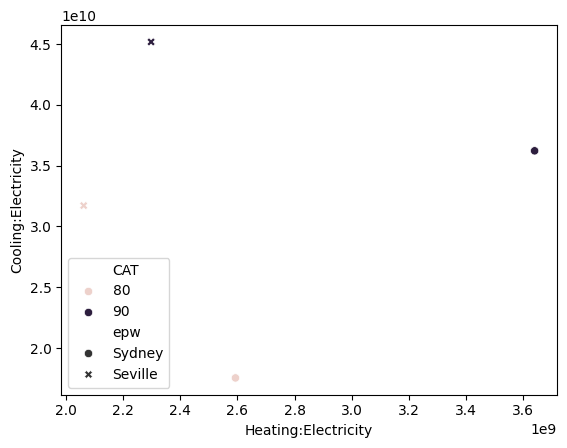

In [37]:
sns.scatterplot(
    data=parametric.outputs_param_simulation,
    x='Heating:Electricity',
    y='Cooling:Electricity',
    hue='CAT',
    style='epw'
)

#### Time series columns

If you requested some output to be reported in time series, you can get a dataframe containing the hourly values using the method `get_hourly_df()`. This dataframe is saved in the internal variable `outputs_param_simulation_hourly`:

In [38]:
parametric.get_hourly_df()
parametric.outputs_param_simulation_hourly

ComfStand  CAT  ComfMod      epw  hour            datetime  \
0              2   80        3   Sydney     1 2024-01-01 01:00:00   
1              2   80        3   Sydney     2 2024-01-01 02:00:00   
2              2   80        3   Sydney     3 2024-01-01 03:00:00   
3              2   80        3   Sydney     4 2024-01-01 04:00:00   
4              2   80        3   Sydney     5 2024-01-01 05:00:00   
...          ...  ...      ...      ...   ...                 ...   
35035          2   90        3  Seville  8756 2024-12-30 20:00:00   
35036          2   90        3  Seville  8757 2024-12-30 21:00:00   
35037          2   90        3  Seville  8758 2024-12-30 22:00:00   
35038          2   90        3  Seville  8759 2024-12-30 23:00:00   
35039          2   90        3  Seville  8760 2024-12-31 00:00:00   

       Adaptive Cooling Setpoint Temperature_No Tolerance_time series  \
0                                              27.325804                
1                                              27.910965                
2                                              27.910965                
3                                              27.910965                
4                                              27.910965                
...                                                  ...                
35035                                          23.933430                
35036                                          23.933430                
35037                                          23.933430                
35038                                          23.933430                
35039                                          23.933430                

       Adaptive Heating Setpoint Temperature_No Tolerance_time series  \
0                                              20.325804                
1                                              20.910965                
2                                              20.910965                
3                                              20.910965                
4                                              20.910965                
...                                                  ...                
35035                                          18.933430                
35036                                          18.933430                
35037                                          18.933430                
35038                                          18.933430                
35039                                          18.933430                

       Zone Operative Temperature_time series  \
0                                   23.771739   
1                                   23.897365   
2                                   23.759499   
3                                   23.810121   
4                                   24.115131   
...                                       ...   
35035                               23.617957   
35036                               23.571012   
35037                               23.340480   
35038                               23.060501   
35039                               22.838352   

       Zone Thermal Comfort ASHRAE 55 Adaptive Model Running Average Outdoor Air Temperature_time series  
0                                              21.325694                                                  
1                                              21.325694                                                  
2                                              21.325694                                                  
3                                              21.325694                                                  
4                                              21.325694                                                  
...                                                  ...                                                  
35035                                          11.720741                              

Let's prepare the `outputs_param_simulation_hourly` df for plotting:

In [39]:
#Let's make a copy of the dataframe to not to modify the original one
df = parametric.outputs_param_simulation_hourly.copy()

# The name of the column for the Running mean outdoor temperature is very long, so let's save it in the variable rmot:
rmot = [i for i in df.columns if 'Running Average' in i][0]

#Let's remove the columns where value is the same for all rows
for c in df.columns:
    if len(set(df[c])) == 1:
        df = df.drop(columns=[c])
#Now let's remove the hour and datetime columns, since will
df = df.drop(columns=['hour'])

# Now let's reshape the df for plotting purposes
df = df.melt(id_vars=['datetime', 'CAT', 'epw', rmot])


Firstly, we're going to plot the hourly temperatures to see the slope of the comfort model, and check all hours are within thermal comfort limits (since we applied adaptive setpoints)

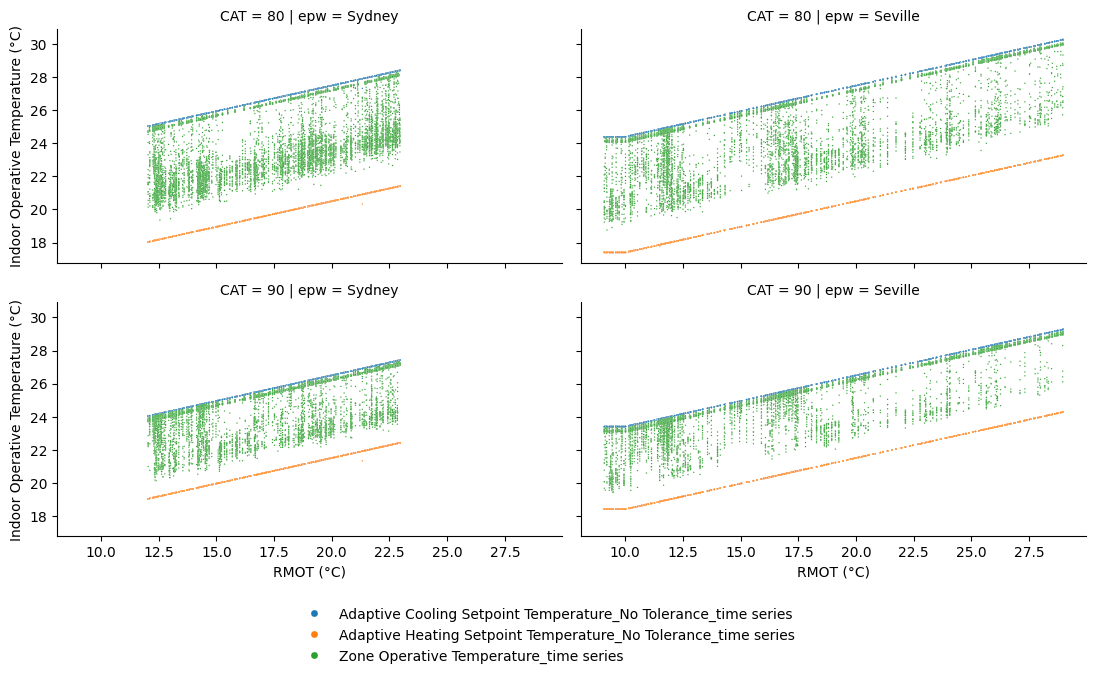

In [45]:
g = sns.FacetGrid(
    data=df,
    row='CAT',
    col='epw'
)
g.map_dataframe(
    sns.scatterplot,
    x=rmot,
    y='value',
    hue='variable',
    s=1,
    #alpha=0.5
)
g.set_axis_labels('RMOT (°C)', 'Indoor Operative Temperature (°C)')
g.add_legend(loc='upper center', bbox_to_anchor=(0.5, 0))

for lh in g._legend.legend_handles:
    lh.set_markersize(5)
plt.tight_layout()


Now, we're going to plot time on x-axis and change the plot type to lineplot, to see the variarion of the indoor operative temperature throughout the year:

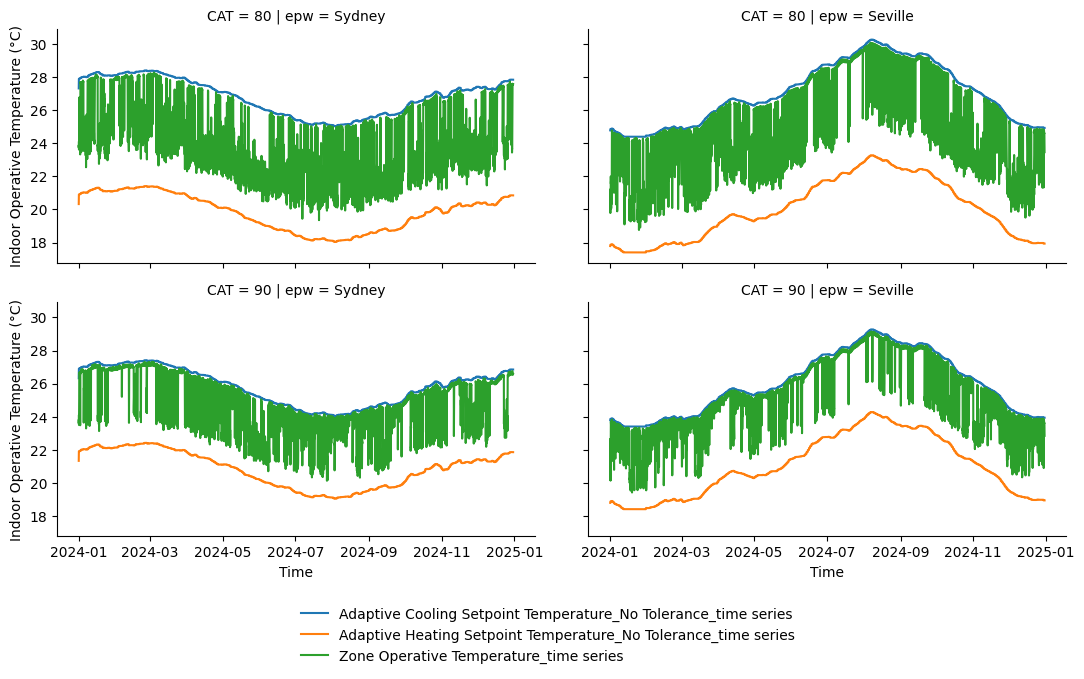

In [44]:
g = sns.FacetGrid(
    data=df,
    row='CAT',
    col='epw'
)
g.map_dataframe(
    sns.lineplot,
    x='datetime',
    y='value',
    hue='variable',
)
g.set_axis_labels('Time', 'Indoor Operative Temperature (°C)')
g.add_legend(loc='upper center', bbox_to_anchor=(0.5, 0))
plt.tight_layout()


We're done with the example, so let's remove all new files, so that we can re-run it again.

In [48]:
current_files = [i for i in listdir()]
new_files = set(current_files) - set(original_files)
new_files

{'available_outputs', 'notebook_temp_dir'}

In [51]:
import os
import shutil
for item in new_files:
    item_path = os.path.join(os.getcwd(), item)
    if os.path.isfile(item_path):
        os.remove(item_path)
    elif os.path.isdir(item_path):
        shutil.rmtree(item_path)